In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:            25G        729M         24G        932K        785M         24G
Swap:            0B          0B          0B


In [1]:
import os
print(os.getcwd())
os.chdir('/content/drive/My Drive/Google Colab/kaggle/PlantPathology')
print(os.getcwd())

/content
/content/drive/My Drive/Google Colab/kaggle/PlantPathology


In [0]:
# !unzip plant-pathology-2020-fgvc7.zip

In [3]:
!ls

images				submit.csv
plant-pathology-2020-fgvc7.zip	test.csv
PlantPathology.ipynb		train.csv
sample_submission.csv		weights_fine_tuning_drill.pth


In [0]:
import pandas as pd
from os.path import join
from glob import glob
from itertools import chain
from PIL import Image
from torchvision import datasets, models, transforms
import torch.utils.data as data

In [5]:
_data = pd.read_csv("train.csv")

healthy = (_data['healthy'][_data['healthy'] == 1])
multiple_diseases = (_data['multiple_diseases'][_data['multiple_diseases'] == 1])	
rust = (_data['rust'][_data['rust'] == 1])
scab = (_data['scab'][_data['scab'] == 1])

print("healthy:" , len(healthy))
print("multiple_diseases:" , len(multiple_diseases))
print("rust:" , len(rust))
print("scab:", len(scab))

TRAIN_HEALTHY_NUM = int(len(healthy) * 0.8)
print(TRAIN_HEALTHY_NUM)

TRAIN_MULTIPLE_NUM = int(len(multiple_diseases) * 0.8)
print(TRAIN_MULTIPLE_NUM)

TRAIN_RUST_NUM = int(len(rust) * 0.8)
print(TRAIN_RUST_NUM)

TRAIN_SCAB_NUM = int(len(scab) * 0.8)
print(TRAIN_SCAB_NUM)


healthy: 516
multiple_diseases: 91
rust: 622
scab: 592
412
72
497
473


In [0]:
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(
                    resize, scale=(0.5, 1.0)),  # データオーギュメンテーション
                transforms.RandomHorizontalFlip(),  # データオーギュメンテーション
                transforms.ToTensor(),  # テンソルに変換
                transforms.Normalize(mean, std)  # 標準化
            ]),
            'val': transforms.Compose([
                transforms.Resize(resize),  # リサイズ
                transforms.CenterCrop(resize),  # 画像中央をresize×resizeで切り取り
                transforms.ToTensor(),  # テンソルに変換
                transforms.Normalize(mean, std)  # 標準化
            ])
        }

    def __call__(self, img, phase='train'):
        return self.data_transform[phase](img)


In [0]:
def make_datapath_list(phase, class_data):
    TRAIN_MAX = {'healthy': TRAIN_HEALTHY_NUM, 'multiple_diseases': TRAIN_MULTIPLE_NUM, 'rust': TRAIN_RUST_NUM, 'scab': TRAIN_SCAB_NUM}
    train_list = []
    val_list = []
    class_names = ['healthy', 'multiple_diseases', 'rust', 'scab']
    count = {'healthy': 0, 'multiple_diseases': 0, 'rust': 0, 'scab': 0}

    for i in range(0, 1821):
        path = join("images", class_data.iloc[i, 0] + '.jpg')

        for j in range(1, 5):
            if class_data.iloc[i, j] == 1:
                if TRAIN_MAX[class_names[j - 1]] >= count[class_names[j - 1]]:
                    train_list.append(path)
                else:
                    val_list.append(path)
                
                count[class_names[j - 1]] += 1
                break

    
    return train_list, val_list


In [0]:
class LoadDataset(data.Dataset):
    
    def __init__(self, file_list, transform=None, phase='train', class_data=None):
        self.file_list = file_list  # ファイルパスのリスト
        self.transform = transform  # 前処理クラスのインスタンス
        self.phase = phase  # train or valの指定
        self.class_data = class_data
        
    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        # index番目の画像をロード
        img_path = self.file_list[index]
        img = Image.open(img_path).convert("RGB")  # [高さ][幅][色RGB]

        # 画像の前処理を実施
        img_transformed = self.transform(
            img, self.phase)  # torch.Size([3, 224, 224])
        
        row = int(img_path[13:-4])
        _class_data = self.class_data.iloc[row]
        for i in range(1, 5):
            if _class_data[i] == 1:
                label = i - 1
        
        # 画像のラベルをファイル名から抜き出す
        return img_transformed, label

In [0]:
def make_dataLoader():
    
    size = 224
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)
    
    class_data = pd.read_csv("train.csv")

    batch_size = 128
    # trainとvalの画像へのパスを作成
    train_list, val_list = make_datapath_list(phase="val", class_data=class_data)

    # Datasetを作成する
    train_dataset = LoadDataset(
        file_list=train_list, transform=ImageTransform(size, mean, std), phase='train', class_data=class_data)

    val_dataset = LoadDataset(
        file_list=val_list, transform=ImageTransform(size, mean, std), phase='val', class_data=class_data)


    # DataLoaderを作成する
    train_dataloader = data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True)

    val_dataloader = data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False)

    # 辞書オブジェクトにまとめる
    dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

    return dataloaders_dict

In [0]:
 #モジュールのインポート
import random, yaml
import torch, torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm
from random import seed, sample
from sklearn.metrics import classification_report
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
def fine_tuning_VGG16():
    # VGG-16モデルのインスタンスを生成
    use_pretrained = True  # 学習済みのパラメータを使用
    net = models.vgg16(pretrained=use_pretrained)

    net.classifier[6] = nn.Linear(in_features = 4096, out_features = 4)

    # 訓練モードに設定
    net.train()
    print('ネットワーク設定完了：学習済みの重みをロードし、訓練モードに設定しました')

    #以下fine turning
    params_to_update_1 = []
    params_to_update_2 = []
    params_to_update_3 = []

    # 学習させる層のパラメータ名を指定
    update_param_names_1 = ["features.26.weight", "features.26.bias", "features.28.weight", "features.28.bias"]
    update_param_names_2 = ["classifier.0.weight",
                            "classifier.0.bias", "classifier.3.weight", "classifier.3.bias"]
    update_param_names_3 = ["classifier.6.weight", "classifier.6.bias"]

    # パラメータごとに各リストに格納する
    for name, param in net.named_parameters():
        if name in update_param_names_1:
            param.requires_grad = True
            params_to_update_1.append(param)
            print("params_to_update_1に格納：", name)

        elif name in update_param_names_2:
            param.requires_grad = True
            params_to_update_2.append(param)
            print("params_to_update_2に格納：", name)

        elif name in update_param_names_3:
            param.requires_grad = True
            params_to_update_3.append(param)
            print("params_to_update_3に格納：", name)

        else:
            param.requires_grad = False
            print("勾配計算なし。学習しない：", name)
        
        print('fine_tuning設定完了')
        # Optimizer設定
    optimizer = optim.SGD([
        {'params': params_to_update_1, 'lr': 5e-4},
        {'params': params_to_update_2, 'lr': 1e-3},
        {'params': params_to_update_3, 'lr': 5e-3}
    ], momentum=0.9)

    return net,optimizer

In [0]:
def do_train_return_dic(net, dataloader_dict, criterion, optimizer, num_epochs):

    # 初期設定
    # GPUが使えるかを確認
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("使用デバイス：", device)

    # ネットワークをGPUへ
    net = net.to(device)
    if device == 'cuda':
        net = torch.nn.DataParallel(net) # make parallel

        # ネットワークがある程度固定であれば、高速化させる
        torch.backends.cudnn.benchmark = True


    epoch_loss_dic = {}
    epoch_acc_dic = {}

    # epochのループ
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epochごとの訓練と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
            else:
                net.eval()   # モデルを検証モードに

            epoch_loss = 0.0  # epochの損失和
            epoch_corrects = 0  # epochの正解数

            # 未学習時の検証性能を確かめるため、epoch=0の訓練は省略
            if (epoch == 0) and (phase == 'train'):
                continue

            # データローダーからミニバッチを取り出すループ
            for inputs, labels in tqdm(dataloader_dict[phase]):

                # GPUが使えるならGPUにデータを送る
                inputs = inputs.to(device)
                labels = labels.to(device)

                # optimizerを初期化
                optimizer.zero_grad()


                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)  # 損失を計算
                    _, preds = torch.max(outputs, 1)  # ラベルを予測

                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # 結果の計算
                    epoch_loss += loss.item() * inputs.size(0)  # lossの合計を更新
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)

            # epochごとのlossと正解率を表示
            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double(
            ) / len(dataloader_dict[phase].dataset)

            epoch_loss_dic.setdefault(phase, []).append(epoch_loss)
            epoch_acc_dic.setdefault(phase, []).append(epoch_acc.to("cpu").item())

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
    # PyTorchのネットワークパラメータの保存
    save_path = './weights_fine_tuning_drill.pth'
    torch.save(net.state_dict(), save_path)
    
    return epoch_loss_dic, epoch_acc_dic

In [0]:
def do_test(dataloaders_dict):
    net = models.vgg16(False)
    net.classifier[6] = nn.Linear(in_features=4096, out_features=4)
    net_weights = torch.load('./weights_fine_tuning_drill.pth', map_location={'cuda': 'cpu'})
    from collections import OrderedDict
    new_state_dict = OrderedDict()

    for k, v in net_weights.items():
        k = k[7:]
        new_state_dict[k]=v

    net.load_state_dict(new_state_dict)

    
    net.eval()

    Y,pred = [], []
    for inputs, labels in tqdm(dataloaders_dict["val"]):
        outputs = net(inputs)
        pred += [int(l.argmax()) for l in outputs]
        Y += [int(l) for l in labels]
    
    print(classification_report(Y, pred))

In [0]:
 def plot_history_loss(loss):
    # hist.historyに辞書型で損失値や精度が入っているので取得して表示
    plt.plot(loss['train'],label="loss for training")
    plt.plot(loss['val'],label="loss for validation")
    
    #matplotlibの細かい設定
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='best')
    
    plt.show()
    

def plot_history_acc(acc):
    plt.plot(acc['train'],label="acc for training")
    plt.plot(acc['val'],label="acc for validation")
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc='best')
    plt.ylim([0, 1])
    plt.show()

In [0]:
def main():
    dataloaders_dict = make_dataLoader() #trとvalのデータ整形
    
    net,optimizer = fine_tuning_VGG16() # VGGF16モデルを読み込む
    criterion = nn.CrossEntropyLoss()  # 損失関数の設定
    
    # 学習・検証を実行する
    num_epochs = 40
    epoch_loss_dic, epoch_acc_dic = do_train_return_dic(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)
    
    plot_history_loss(epoch_loss_dic)

    plot_history_acc(epoch_acc_dic)

    # 検証
    # do_test(dataloaders_dict)



  0%|          | 0/3 [00:00<?, ?it/s]

ネットワーク設定完了：学習済みの重みをロードし、訓練モードに設定しました
勾配計算なし。学習しない： features.0.weight
fine_tuning設定完了
勾配計算なし。学習しない： features.0.bias
fine_tuning設定完了
勾配計算なし。学習しない： features.2.weight
fine_tuning設定完了
勾配計算なし。学習しない： features.2.bias
fine_tuning設定完了
勾配計算なし。学習しない： features.5.weight
fine_tuning設定完了
勾配計算なし。学習しない： features.5.bias
fine_tuning設定完了
勾配計算なし。学習しない： features.7.weight
fine_tuning設定完了
勾配計算なし。学習しない： features.7.bias
fine_tuning設定完了
勾配計算なし。学習しない： features.10.weight
fine_tuning設定完了
勾配計算なし。学習しない： features.10.bias
fine_tuning設定完了
勾配計算なし。学習しない： features.12.weight
fine_tuning設定完了
勾配計算なし。学習しない： features.12.bias
fine_tuning設定完了
勾配計算なし。学習しない： features.14.weight
fine_tuning設定完了
勾配計算なし。学習しない： features.14.bias
fine_tuning設定完了
勾配計算なし。学習しない： features.17.weight
fine_tuning設定完了
勾配計算なし。学習しない： features.17.bias
fine_tuning設定完了
勾配計算なし。学習しない： features.19.weight
fine_tuning設定完了
勾配計算なし。学習しない： features.19.bias
fine_tuning設定完了
勾配計算なし。学習しない： features.21.weight
fine_tuning設定完了
勾配計算なし。学習しない： features.21.bias
fine_tuning設定完了
勾配計算なし。学習しな

  0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.5653 Acc: 0.0854
Epoch 2/40
-------------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 1.1907 Acc: 0.4993


  0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.7303 Acc: 0.7300
Epoch 3/40
-------------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.6547 Acc: 0.7599


  0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.5368 Acc: 0.8209
Epoch 4/40
-------------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.5223 Acc: 0.8272


  0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.4485 Acc: 0.8485
Epoch 5/40
-------------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.4271 Acc: 0.8450


  0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.3686 Acc: 0.8705
Epoch 6/40
-------------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.3716 Acc: 0.8683


  0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.3401 Acc: 0.8871
Epoch 7/40
-------------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.3422 Acc: 0.8855


  0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.3238 Acc: 0.8843
Epoch 8/40
-------------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.3084 Acc: 0.8937


  0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.3020 Acc: 0.9008
Epoch 9/40
-------------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.3010 Acc: 0.9040


  0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.2838 Acc: 0.8926
Epoch 10/40
-------------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.2820 Acc: 0.9060


  0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.2908 Acc: 0.8981
Epoch 11/40
-------------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.2905 Acc: 0.9067


  0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.2926 Acc: 0.9118
Epoch 12/40
-------------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.2721 Acc: 0.9115


  0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.2594 Acc: 0.9036
Epoch 13/40
-------------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.2443 Acc: 0.9218


  0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.2544 Acc: 0.8981
Epoch 14/40
-------------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.2407 Acc: 0.9204


  0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.2631 Acc: 0.9008
Epoch 15/40
-------------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.2155 Acc: 0.9252


  0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.2999 Acc: 0.9118
Epoch 16/40
-------------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.2137 Acc: 0.9239


  0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.2485 Acc: 0.9063
Epoch 17/40
-------------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.2353 Acc: 0.9266


  0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.2664 Acc: 0.8926
Epoch 18/40
-------------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.2144 Acc: 0.9273


  0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.2602 Acc: 0.9063
Epoch 19/40
-------------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.2133 Acc: 0.9314


  0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.2436 Acc: 0.9146
Epoch 20/40
-------------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.2220 Acc: 0.9239


  0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.2598 Acc: 0.9118
Epoch 21/40
-------------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.1914 Acc: 0.9335


  0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.2683 Acc: 0.9091
Epoch 22/40
-------------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.1895 Acc: 0.9294


  0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.2405 Acc: 0.9201
Epoch 23/40
-------------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.2061 Acc: 0.9232


  0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.2336 Acc: 0.9146
Epoch 24/40
-------------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.1810 Acc: 0.9458


  0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.2646 Acc: 0.9174
Epoch 25/40
-------------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.1903 Acc: 0.9321


  0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.2323 Acc: 0.9201
Epoch 26/40
-------------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.1706 Acc: 0.9438


  0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.2461 Acc: 0.9229
Epoch 27/40
-------------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.1786 Acc: 0.9431


  0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.2284 Acc: 0.9201
Epoch 28/40
-------------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.1614 Acc: 0.9479


  0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.2543 Acc: 0.9174
Epoch 29/40
-------------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.1677 Acc: 0.9444


  0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.2214 Acc: 0.9284
Epoch 30/40
-------------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.1523 Acc: 0.9451


  0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.2498 Acc: 0.9229
Epoch 31/40
-------------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.1447 Acc: 0.9513


  0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.2604 Acc: 0.9256
Epoch 32/40
-------------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.1402 Acc: 0.9520


  0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.2489 Acc: 0.9284
Epoch 33/40
-------------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.1556 Acc: 0.9486


  0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.2773 Acc: 0.9146
Epoch 34/40
-------------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.1362 Acc: 0.9540


  0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.2546 Acc: 0.9174
Epoch 35/40
-------------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.1567 Acc: 0.9424


  0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.2427 Acc: 0.9284
Epoch 36/40
-------------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.1452 Acc: 0.9424


  0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.2784 Acc: 0.9063
Epoch 37/40
-------------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.1584 Acc: 0.9472


  0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.2518 Acc: 0.9256
Epoch 38/40
-------------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.1449 Acc: 0.9506


  0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.2710 Acc: 0.9036
Epoch 39/40
-------------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.1491 Acc: 0.9458


  0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.2382 Acc: 0.9284
Epoch 40/40
-------------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.1268 Acc: 0.9554


100%|██████████| 3/3 [00:20<00:00,  6.98s/it]


val Loss: 0.2326 Acc: 0.9284


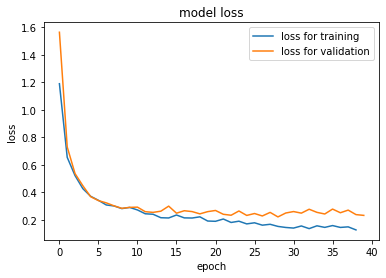

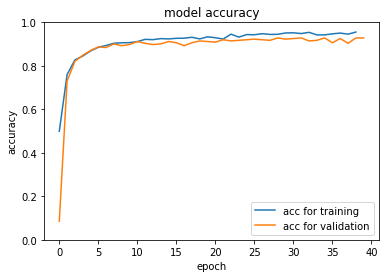

 67%|██████▋   | 2/3 [01:27<00:43, 43.63s/it]

In [0]:
if __name__=='__main__':
    # 乱数のシードを設定
    torch.manual_seed(1234)
    np.random.seed(1234)
    random.seed(1234)
    
    main()

In [0]:
# net = models.vgg16(False)
# net.classifier[6] = nn.Linear(in_features=4096, out_features=4)
# net_weights = torch.load('./weights_fine_tuning_drill.pth', map_location={'cuda': 'cpu'})
# from collections import OrderedDict
# new_state_dict = OrderedDict()

# for k, v in net_weights.items():
#     k = k[7:]
#     new_state_dict[k]=v

# net.load_state_dict(new_state_dict)

In [0]:
# dataloaders_dict = make_dataLoader() #trとvalのデータ整形

# net.eval()

# Y,pred = [], []
# for inputs, labels in tqdm(dataloaders_dict["val"]):
#     outputs = net(inputs)
#     pred += [int(l.argmax()) for l in outputs]
#     Y += [int(l) for l in labels]

# print(classification_report(Y, pred))

In [14]:
test = pd.read_csv("test.csv")
test_path_list = [join('images', path + '.jpg') for path in chain.from_iterable(test.values.tolist())]

size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

test_transform = transforms.Compose([
                transforms.Resize(size),  # リサイズ
                transforms.CenterCrop(size),  # 画像中央をresize×resizeで切り取り
                transforms.ToTensor(),  # テンソルに変換
                transforms.Normalize(mean, std)  # 標準化
            ])
trained_net = models.vgg16(False)
trained_net.classifier[6] = nn.Linear(in_features=4096, out_features=4)
net_weights = torch.load('./weights_fine_tuning_drill.pth', map_location={'cuda': 'cpu'})
from collections import OrderedDict
new_state_dict = OrderedDict()

for k, v in net_weights.items():
    k = k[7:]
    new_state_dict[k]=v

trained_net.load_state_dict(new_state_dict)


trained_net.eval()

preds = []
# print(test_path_list)
# img = Image.open(test_path_list[0]).convert("RGB")
# img_transformed = test_transform(img).unsqueeze(0)
# o = trained_net(img_transformed)
# pred = int(o.argmax())
# print(pred)

for path in tqdm(test_path_list):
    img = Image.open(path).convert("RGB")  # [高さ][幅][色RGB]

    img_transformed = test_transform(img).unsqueeze(0)  # torch.Size([3, 224, 224])
    
    output = trained_net(img_transformed)
    preds += [int(output.argmax())]

  0%|          | 0/1821 [00:00<?, ?it/s]

['images/Test_0.jpg', 'images/Test_1.jpg', 'images/Test_2.jpg', 'images/Test_3.jpg', 'images/Test_4.jpg', 'images/Test_5.jpg', 'images/Test_6.jpg', 'images/Test_7.jpg', 'images/Test_8.jpg', 'images/Test_9.jpg', 'images/Test_10.jpg', 'images/Test_11.jpg', 'images/Test_12.jpg', 'images/Test_13.jpg', 'images/Test_14.jpg', 'images/Test_15.jpg', 'images/Test_16.jpg', 'images/Test_17.jpg', 'images/Test_18.jpg', 'images/Test_19.jpg', 'images/Test_20.jpg', 'images/Test_21.jpg', 'images/Test_22.jpg', 'images/Test_23.jpg', 'images/Test_24.jpg', 'images/Test_25.jpg', 'images/Test_26.jpg', 'images/Test_27.jpg', 'images/Test_28.jpg', 'images/Test_29.jpg', 'images/Test_30.jpg', 'images/Test_31.jpg', 'images/Test_32.jpg', 'images/Test_33.jpg', 'images/Test_34.jpg', 'images/Test_35.jpg', 'images/Test_36.jpg', 'images/Test_37.jpg', 'images/Test_38.jpg', 'images/Test_39.jpg', 'images/Test_40.jpg', 'images/Test_41.jpg', 'images/Test_42.jpg', 'images/Test_43.jpg', 'images/Test_44.jpg', 'images/Test_45.jpg

100%|██████████| 1821/1821 [16:50<00:00,  1.80it/s]


In [15]:
print(len(preds))

1821


In [0]:
id_list = [p[7:-4] for p in test_path_list]

pred_dict = {'healthy': [0] * 1821, 'multiple_diseases': [0] * 1821, 'rust': [0] * 1821, 'scab': [0] * 1821}
class_list = ['healthy', 'multiple_diseases', 'rust', 'scab']

for i, pred in enumerate(preds):
    pred_dict[class_list[pred]][i] = 1

submit_file = pd.DataFrame({'image_id':id_list, 'healthy': pred_dict['healthy'], 'multiple_diseases': pred_dict['multiple_diseases'], 'rust': pred_dict['rust'], 'scab': pred_dict['scab']})
submit_file.to_csv('submit.csv', index = False)